In [28]:
import os
os.chdir('..')
import numpy as np
from data_sets import SynData
import matplotlib.pyplot as plt
from syn_data_functionality.gen_input_from_label import *
import skimage.io

In [29]:
print(os.getcwd())
synDat = SynData("syn_data/syn_input", "syn_data/syn_label")

img, lab = synDat[0]

data = lab[0].numpy()
print(data.shape)
plt.imshow(data)

c:\Users\nugni\OneDrive\Skrivebord\Bachelor\git\Bachelor_rep_angiograms


FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'syn_data/syn_input'

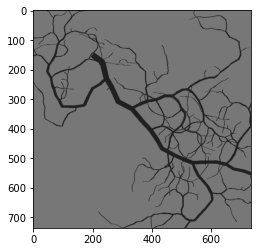

In [ ]:
arr = np.array(data.copy()).astype(float)
#print(arr)
bc, ac = gen_colors()
#print(bc)
arr[data == 1] = ac#/255
#print(arr)
arr[data == 0] = bc#/255
#print(arr)
plt.imshow(arr, vmax=255, vmin=0, cmap="gray")

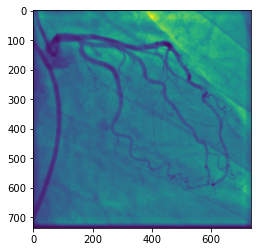

In [ ]:
path_4_33 = r"Z:\dikuAngiograms\Data\02\ImsegmentedPt_02 V_4\ImsegmentedPt_02 V_4\Orig\IMG00004_33.tiff"
#r"../../../Orig_data/ImsegmentedPt_02 V_4/IMG00004_33.tiff"

img_4_33 = np.array(skimage.io.imread(path_4_33))

plt.imshow(img_4_33)

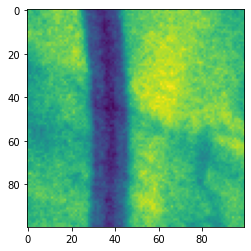

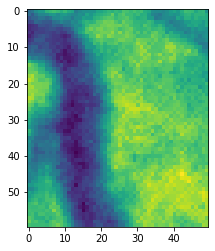

In [ ]:
plt.imshow(img_4_33[300:400, 50: 150])
plt.show()
plt.imshow(img_4_33[240:300, 430: 480])

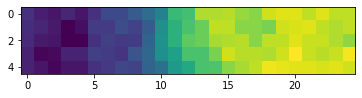

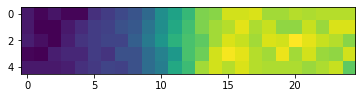

In [ ]:
plt.imshow(img_4_33[335:340, 85: 110])
plt.show()
plt.imshow(img_4_33[270:275, 440: 465])

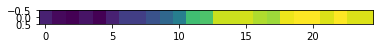

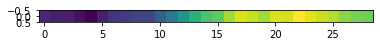

In [ ]:
slice1 = img_4_33[335:336,85:110]
slice2 = img_4_33[272:273, 438: 467]
plt.imshow(slice1)
plt.show()
plt.imshow(slice2)

Evt.: sæt min-val til 0. Dette ændrer ikke std, men gør det lettere at arbejde med. 
Alternativt træk konstant fra data. Dette ændrer ikke std.
Gang data med en eller anden konstant c så data er maks 0. Std er så normaliseret datas std divideret med konstant c 

25
25


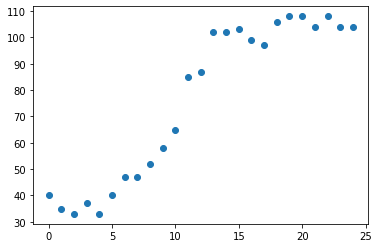

29
29


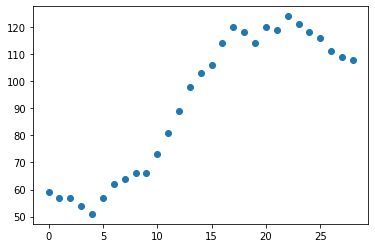

In [ ]:
x = np.arange(len(slice1[0]))
print(len(x))
print(len(slice1[0]))
plt.scatter(x, slice1[0])
plt.show()

x2 = np.arange(len(slice2[0]))
print(len(x2))
print(len(slice2[0]))
plt.scatter(x2, slice2[0])
plt.show()

In [67]:
#taken from
#https://stackoverflow.com/questions/60160803/scipy-optimize-curve-fit-for-logistic-function
from scipy.optimize import curve_fit
#fit curve to logistic regression function.
#A is distance between highest and lowest y
#x0 is midpoint
#k is growth rate
#off is how far we are off x=0
def logifunc(x, A, x0, k, off):
    return A / (1 + np.exp(-k*(x-x0)))+off

def logiDerived(x, A, k, x0):
    return A*k*(np.exp(-k*(x-x0)))/np.power((1+np.exp(-k*(x-x0))), 2)

def gauss(x, A, x0, var):
    return A * np.exp(-(x - x0)**2 / (2 * var))

In [195]:
def fitSliceToLogi(imgSlice, guess=None):
    y = imgSlice
    x = np.arange(len(imgSlice))
    popt, pcov = curve_fit(logifunc, x, y, p0=guess)
    return popt


popt1 = fitSliceToLogi(slice1[0], [90,10,0.3,30])
popt2 = fitSliceToLogi(slice2[0], [90,10,0.3,30])


In [74]:
A, x0, k, off = popt1[0], popt1[1], popt1[2], popt1[3]

In [199]:
def find_gauss_from_logi(popt, slicei, illustrate=False, path = None, file_name=None, num_samples=2000):
    x = np.linspace(0, len(slicei)-1, num=num_samples)
    A, x0, k = popt[0], popt[1], popt[2]
    y_logi = logiDerived(x, A, k, x0)

    popt_g, pcov_g = curve_fit(gauss, x, y_logi)

    if illustrate:
        plt.title("Gaussian fitted to the derivation of logistic fit")
        plt.xlabel("Pixel value")
        plt.ylabel("Pixel index in slice")

        plt.plot(x, y_logi, label="g : Derivation of f")

        y_gauss = gauss(x, popt_g[0], popt_g[1], popt_g[2])
        plt.plot(x, y_gauss, label="h : Guassian fit of g")

        plt.legend()
        plt.savefig(path + "/" + file_name)
        #plt.plot()

    return popt_g


In [207]:
file_path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\git\Bachelor_rep_angiograms\src\images_report"
#slicey = slice1[0]

slices = [slice1[0], slice2[0]]
stds = []
for s in slices:
    print(s)
    guess = [np.max(s)-np.min(s), len(s)/2, 0.3, np.min(s)]
    popt = fitSliceToLogi(s, guess)
    popt_g = find_gauss_from_logi(popt1, s)#, True, file_path, "gauss_fit_logi_derived.PNG")
    std = np.sqrt(popt_g[2])
    stds.append(std)


print(stds)

[ 40  35  33  37  33  40  47  47  52  58  65  85  87 102 102 103  99  97
 106 108 108 104 108 104 104]
[ 59  57  57  54  51  57  62  64  66  66  73  81  89  98 103 106 114 120
 118 114 120 119 124 121 118 116 111 109 108]
[2.4941396955318202, 2.494139715245726]


In [188]:
def illustrate_slice_fit_and_noise(file_name, path, img_slice, mu_gauss, popt_logi):
    x = np.arange(len(img_slice))
    plt.scatter(x, img_slice, label="Observations")
    A, off = popt_logi[0], popt_logi[3]
    step_x, step_y = [0, mu_gauss, len(img_slice)-1], [off, off+A, off+A]
    plt.plot(step_x, step_y, drawstyle="steps-post", linestyle='dashed', c='gray', label="Assumed ground truth")
    logi_y = logifunc(x, popt_logi[0], popt_logi[1], popt_logi[2], popt_logi[3])
    plt.plot(logi_y, label="f : Logistic fit of obsevations", c='r')
    plt.xlabel("Slice pixel index")
    plt.ylabel("Pixel value")
    plt.title("Logistic fit of observed blood vessel edge and assumed edge")
    plt.legend()
    plt.savefig(path+"/"+file_name)
    #plt.show()

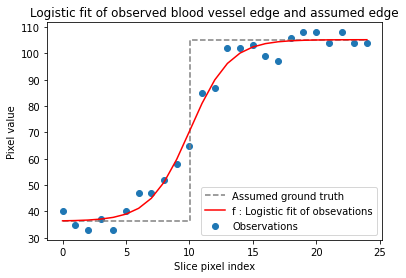

In [189]:
illustrate_slice_fit_and_noise("edge_visualization.PNG" , file_path ,slicey, popt_g[1], popt)


0.11714109343363309


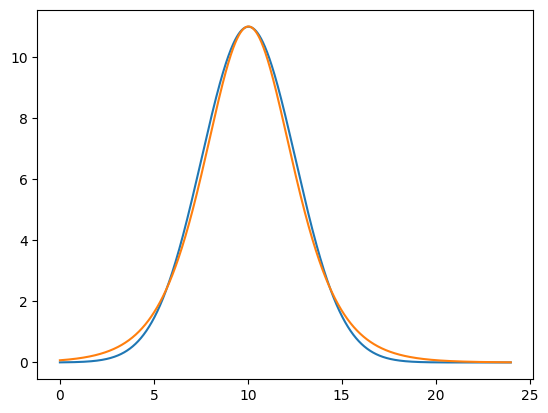

In [ ]:
#plot derived of log reg:
from scipy.stats import norm

#print(logifunc(x, *popt))
#print(logiDerived(x, A, k, x0).shape)

#plt.plot(x, logifunc(x, *popt), 'r-',label='Fitted function')
A = popt1[0]
x0 = popt1[1]
k = popt1[2]
off = popt1[3]

x = np.linspace(0.0, 24, num=2000)
mu = x0
std_big = np.power(np.pi, 2)/(3*np.power(k, 2))
print(std_big/A)
std = np.sqrt(np.sum(np.power(logiDerived(x, A, k, x0) - x0, 2))/2000)
p = A*norm.pdf(x, mu, 2.5)
plt.plot(x, p)
plt.plot(x, logiDerived(x, A, k, x0))
plt.show()


#x2 = np.linspace(0.0, 28, num=1000)
#mu2 = popt2[1]
#A2 = popt2[0]
#k2 = popt[2]
#x02 = mu2
#p2 = A2*norm.pdf(x2, mu2, 2.5)
#plt.plot(x2, p2)
#plt.plot(x2, logiDerived(x2, A2, k2, x02))
#plt.show()

Try and recreate original edge between Blood vessel and background

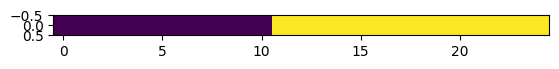

NameError: name 'popt' is not defined

In [ ]:
valmin = off
valmax = off + A
mid = x0

def genOrigDat(vmin, vmax, mid, length):
    arr = np.zeros((1, length))
    for i in range(length):
        if i<mid:
            arr[0, i] = vmin
        else:
            arr[0, i] = vmax
    return arr


origSlice = genOrigDat(valmin, valmax, mid, len(slice1[0]))
plt.imshow(origSlice)
plt.show()

origSlice2 = genOrigDat(popt[3], popt[3]+A2, x02, len(slice2[0]))
plt.imshow(origSlice2)

(1, 25)
(1, 25)


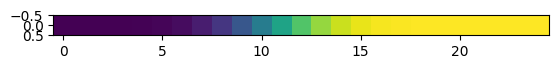

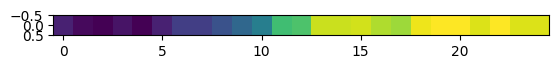

NameError: name 'origSlice2' is not defined

In [ ]:
from scipy.ndimage import gaussian_filter
std = 2.5
print(origSlice.shape)
print(slice1.shape)
filter_result = gaussian_filter(origSlice, sigma=std)
plt.imshow(filter_result)
plt.show()
plt.imshow(slice1)
plt.show()

print(origSlice2.shape)
print(slice2.shape)
filter_result2 = gaussian_filter(origSlice2, sigma=std)
plt.imshow(filter_result2)
plt.show()
plt.imshow(slice2)
plt.show()

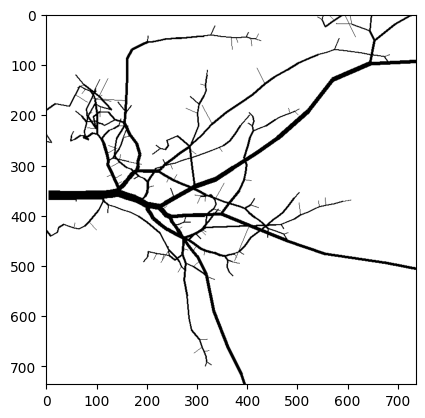

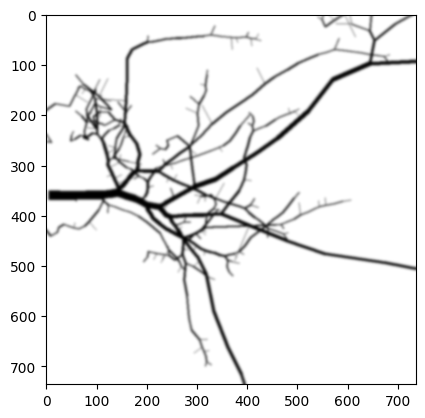

In [ ]:
plt.imshow(arr, cmap="gray")
plt.show()
arr_w_blur = gaussian_filter(arr, sigma=std)
plt.imshow(arr_w_blur, cmap="gray")
plt.show()

In [ ]:
type(arr_w_blur)
print(arr_w_blur.shape)

(736, 736)


In [ ]:
from scipy.stats import poisson

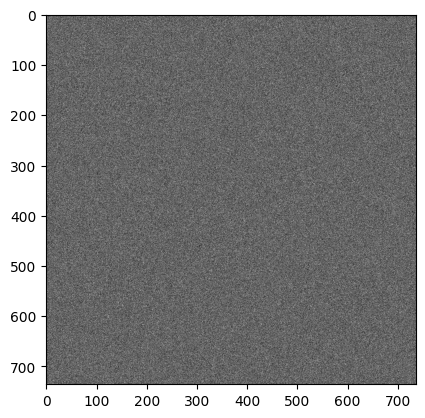

In [ ]:
dim = 736

py = poisson.rvs(22,size=dim*dim)

pyR = np.reshape(py,(736,736))

plt.imshow(pyR,cmap="gray")


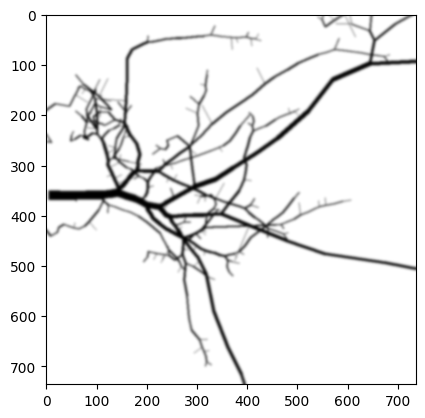

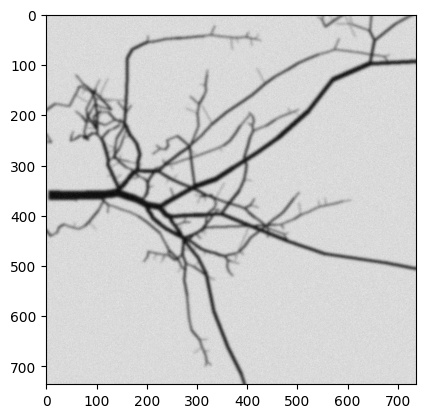

In [ ]:
final = arr_w_blur + pyR
plt.imshow(arr_w_blur, cmap="gray")
plt.show()
plt.imshow(final, cmap="gray")
plt.show()